# Probing the limits of deep learning models on synthetic DNA classification tasks
## Task 1: classify based on 3-mer motifs within 6bp sequence windows

After many unsuccessful attempts to classify _M. buryatense_ promoter sequences into 3 categories (Up, Down, No change) with respect to their genes' transcriptional repsonse to copper, we zoomed back out and designed a simulated version of this task. How much data, or how much signal, would be necessary to train a classifier up to reasonable performance on this task?

The analysis in this notebook covers a simple investigation into the ability of a CNN model to correctly classify very short sequences (6bp windows) based on a synthetic signal of 3-mer motifs.

Part 2 of this analysis investigates longer sequences: see `synthetic_DNAclassification_task2_harder.ipynb`

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from pytorchtools import EarlyStopping

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
tu.set_seed()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

Random seed set as 42


device(type='cuda')

### Load _M. buryatense_ expression data with 300bp upstream regions
This table includes _M. buryatense_ genes that are NOT estimated to be within an operon (the upstream genetic neighbor on the same strand is at >=120 bp away).

Key columns: 
* `locus_tag`: unique locus identifier
* `upstream_region`: 300bp genomic sequence immediately upstream of the gene's start codon. 
* condition columns (e.g. `uMax`, `lowCH4`, etc): gene expression values as the log2 ratio of the gene's measured TPM in the "High Copper" growth condition to the "No Copper" growth condition, averaged within the sample replicates in that condition. (Notice that the "NoCu" column is all 0's because the log2 of 1 = 0)

In [3]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,0.047594,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,0.175844,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,0.087538,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,0.032773,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,0.064979,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,0.008150,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,-0.005709,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,0.015365,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,-0.183282,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502


## Task 1: Synthetic 3-mer motif classification in 6bp seqs
### Add classification label column
Take the first 6 bases of an upstream region. 
* Calculate an average synthetic score based on `score_dict`
* If the sequence contains TAT, give +10 score bump (simulate activating motif)
* If the sequence contains GCG, give -10 score bump (simulate repressing motif)
* Assign sequence class 2 or 0 depending on if the total score exceeds a threshold of +/-5; assign class 1 if score is between -5 and 5. 

In [4]:
# Sequence scoring system. Values are arbitrary (not 
# biologically significant) but designed to create a
# distribution centered at 0. 
score_dict = {
    'A':5,
    'C':2,
    'G':-2,
    'T':-5,
    'N':0
}

def score_seq(seq):
    '''
    Assign sequence a numerical score based on the score_dict
    and motif presence
    '''
    score = np.mean([score_dict[base] for base in seq])
    # simulated "activating" motif
    if 'TAT' in seq:
        score += 10
    # simulated "repressing" motif
    if 'GCG' in seq:
        score -= 10
    return score

def set_task1_class(score,thresh=5):
    '''
    Assign classification labels based on scores exceeding 
    the specified threshold.
    '''
    if score > thresh:
        c = 2 # Simulated "up regulated" class
    elif score < -thresh:
        c = 0 # Simulated "down regulated" class
    else:
        c = 1 # Simulated "no change" class

    return c


In [5]:
# create new column: first 6 bases of each upstream region
XYdf['seq6'] = XYdf['upstream_region'].apply(lambda x: x.strip("N")[:6])
# apply the scoring function
XYdf['score'] = XYdf['seq6'].apply(lambda x: score_seq(x))
# set classification labels
XYdf['task1_class'] = XYdf['score'].apply(lambda x: set_task1_class(x))

XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,seq6,score,task1_class
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,ACTGTT,-1.666667,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,GTGGAC,-0.666667,1
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,TTGCGA,-11.166667,0
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,GTATAA,10.500000,2
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,GAATTT,-1.166667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,TTCCGA,-0.500000,1
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,TTCCGA,-0.500000,1
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,TTGAAA,0.500000,1
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,AATCTT,-0.500000,1


Spot check the distribution of scores

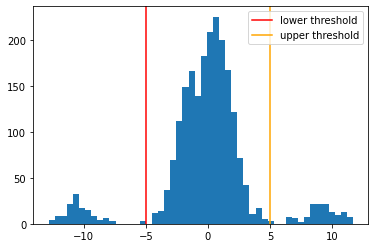

In [6]:
plt.hist(XYdf['score'],bins=50)
plt.axvline(-5, color='red',label='lower threshold')
plt.axvline(5, color='orange',label='upper threshold')
plt.legend()
plt.show()

Check total counts of each class

In [7]:
XYdf[['task1_class']].value_counts()

task1_class
1              1954
2               129
0               128
dtype: int64

### Split the data into train and test sets
Since the classes are imbalanced (majority is Class 1 while Class 0 and Class 2 are minorities). We use StratifiedShuffleSplit to make sure the percent of examples belonging to each class is preserved between train/test splits. 

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit 

# create a splitter object to just make 1 split at 80% train, 20% test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

Train counts:
1    1563
2     103
0     102
Name: task1_class, dtype: int64
Test counts:
1    391
0     26
2     26
Name: task1_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


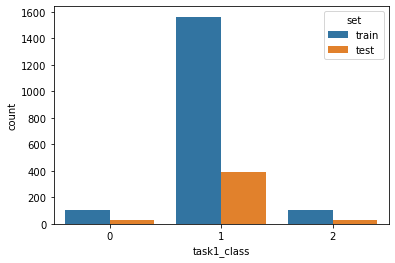

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


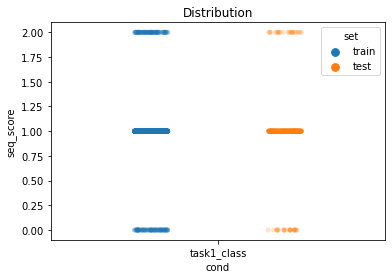

In [9]:
# class label column for synthetic analysis
target_col = 'task1_class'

# get the dataframes generated for the train/test splits 
for i, (train_idxs, test_idxs) in enumerate(sss.split(XYdf, XYdf[target_col])):
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    print(f"Train counts:\n{train_df[target_col].value_counts()}")
    print(f"Test counts:\n{test_df[target_col].value_counts()}")
    
    # a few visualizations of the class balance across splits
    v.plot_train_test_stacks(train_df, test_df, score_col=target_col)
    v.view_train_test_dist(train_df, test_df,[target_col],id_col='locus_tag')


## Load seqs into data loaders
With these splits in hand, load them into PyTorch data loaders for easy access during training

In [10]:
seq_col = 'seq6' # DNA seq column
target_col = 'task1_class' # class label column

# Helper wrapper for working with One-hot encoded DNA
# (instead of K-mers, for example)
dataset_types = [
    DatasetSpec('ohe'),
]

# Create dataloaders "dls" dict of PyTorch DataLoader objects
dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)

# Pull out the DataLoader objects for One-hot encoded DNA
ohe_train_dl,ohe_val_dl = dls['ohe']

View the class split across batches when the DataLoader is called. For now the sampling of examples into batches is quite imbalanced (most examples in each batch are Class 1 ("no change" class)

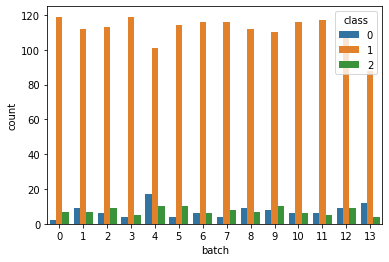

In [11]:
v.see_batch_class_dist(ohe_train_dl)

## Design simple CNN model
For this very simple task, we start with a very simple CNN model. 
* It has 8 convolutional filters, with kernel size 3. 
* It has 1 hidden layer of 10 fully connected nodes
* And a final output layer where it predicts the class label (here it is 3 for the 3 classes)

## Run models and collect performance stats
Set up `model_res` as a model result dictionary with various training info (epochs, validation loss, etc) and `pred_dfs` to record model predictions on various sequence sets so we can calculate model accuracy later. 

In [12]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

E:2999 | train loss:0.002 | val loss: 0.025: 100%|██████████| 3000/3000 [01:50<00:00, 27.03it/s]


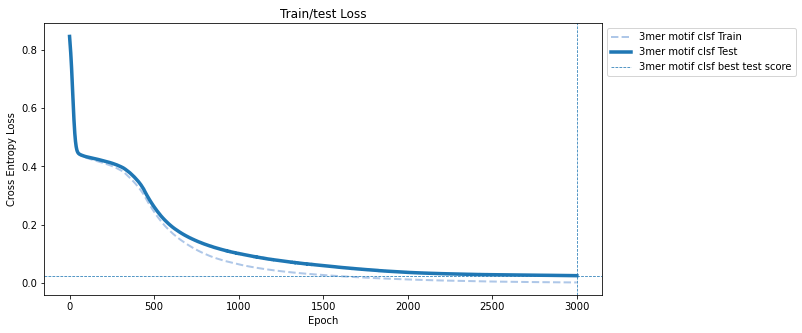

In [13]:
cnn1_name = "3mer motif clsf"

model = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=3,
    fc_node_num=10,
    dropout=0
)

# wrapper function to run model and collect training stats
model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

Here we see the train and test loss curves steadily trending downward to basically 0. But how does the model perform in terms of classification accuracy?

Below, we create a couple sequence sets that we will ask the trained model to predict on. For now, we just pull out the train and test sequences, alongside their classification labels, and label them "train" and "test"


Running predictions for 3mer motif clsf


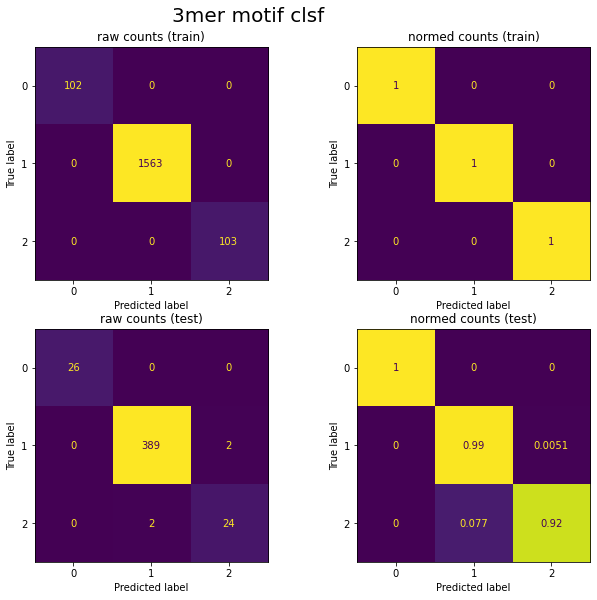

In [14]:
# extract some sequences to predict on
# seq set format: (sequences, labels, set name)
seq_list = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

# Wrapper function that calls the trained model to predict on the above
# list of sequence sets and collects some stats into the "pred_dfs" dict
pred_dfs[cnn1_name] = tu.get_confusion_stats(
    model_res[cnn1_name]['model'],
    model_res[cnn1_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn1_name]['model_name']}"
)

In [15]:
pred_dfs[cnn1_name]

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,3mer motif clsf,train,1.000000,1.000000,1.000000,1768
1,3mer motif clsf,test,0.972654,0.972654,0.972654,443


Even with no data augmentation/sample balancing, scoring based on two 3-mers in a sequence length of 6 is fairly easy to do for this simple CNN: the confusion matrix and precision/recall classification reports achieve very strong performance.

It make sense that this is so easy: the "signal" bases make up half the total bases in the sequence, so the signal is quite dense!

# visualize the filters learned by the model

Total convolutional layers: 1
Num filters 8
filt_width 3
Seq 0 of 1768
Seq 100 of 1768
Seq 200 of 1768
Seq 300 of 1768
Seq 400 of 1768
Seq 500 of 1768
Seq 600 of 1768
Seq 700 of 1768
Seq 800 of 1768
Seq 900 of 1768
Seq 1000 of 1768
Seq 1100 of 1768
Seq 1200 of 1768
Seq 1300 of 1768
Seq 1400 of 1768
Seq 1500 of 1768
Seq 1600 of 1768
Seq 1700 of 1768
torch.Size([8, 4, 3])


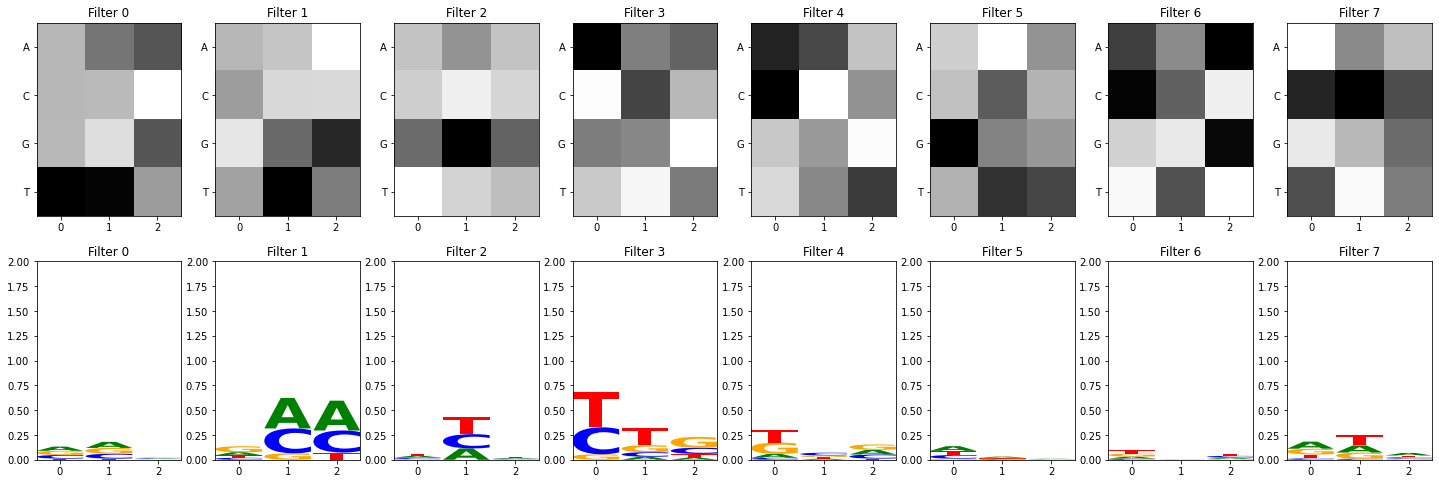

In [16]:
seqs = train_df[seq_col].values
v.view_conv2D_wrapper(model,seqs,DEVICE,act_thresh=0.5,ysc=0.5)

"TAT" and "GCG" don't come out super strongly in the filters for this particular modeling run - perhaps it was easy enough to just combine all the filters indepedently because the signal was pretty clear? _shrug_

# Compare these results to shuffling the input sequences
As a negative control, we redo the analysis using shuffled versions of the input sequences. So each example sequence will retain its original class label we assigned above based on the TAT and GCG presence in the original sequence, but because we shuffle the seqeunce, the class labels should become meaningless, since the motifs that most influenced the scores should be destroyed. 

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


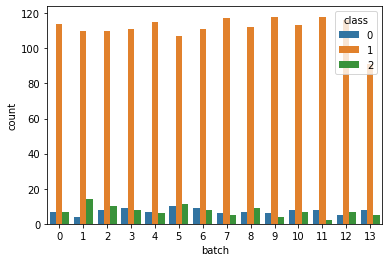

In [17]:
seq_col = 'seq6_shuff'
target_col = 'task1_class'

def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

# add a "shuffled version" of the seq6 column to destroy motifs
train_df[seq_col] = train_df['seq6'].apply(lambda x: shuffle_seq(x))
test_df[seq_col] = test_df['seq6'].apply(lambda x: shuffle_seq(x))

# create new dataloaders that access the shuffled sequence instead of the original
dls_shuff = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)

ohe_train_dl_shuff,ohe_val_dl_shuff = dls_shuff['ohe']

v.see_batch_class_dist(ohe_train_dl_shuff)

## Train a new model on shuffled inputs and collect training stats

E:859 | train loss:0.310 | val loss: 0.335:  29%|██▊       | 858/3000 [00:33<01:21, 26.23it/s]

EarlyStopping counter: 50 out of 200


E:1006 | train loss:0.307 | val loss: 0.334:  34%|███▎      | 1005/3000 [00:38<01:16, 26.19it/s]

EarlyStopping counter: 50 out of 200


E:1056 | train loss:0.306 | val loss: 0.335:  35%|███▌      | 1056/3000 [00:40<01:13, 26.30it/s]

EarlyStopping counter: 100 out of 200


E:1106 | train loss:0.305 | val loss: 0.335:  37%|███▋      | 1107/3000 [00:42<01:12, 26.10it/s]

EarlyStopping counter: 150 out of 200


E:1151 | train loss:0.304 | val loss: 0.335:  38%|███▊      | 1151/3000 [00:44<01:11, 26.03it/s]


EarlyStopping counter: 200 out of 200
Early stopping


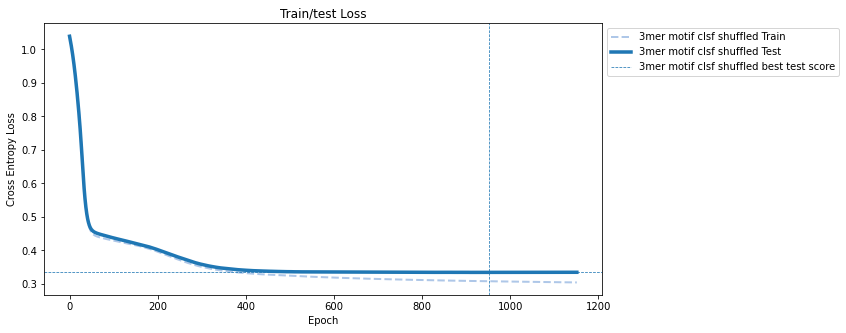

In [18]:
cnn2_name = "3mer motif clsf shuffled"

model2 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=8,
    kernel_size=3,
    fc_node_num=10,
    dropout=0
)

model_res[cnn2_name] = tu.collect_model_stats(
    cnn2_name,
    seq_len,
    ohe_train_dl_shuff,
    ohe_val_dl_shuff,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model2,
    loss_type='classification'
)

Here we can see that the training and test loss curves do not get down to 0. We can look at them side by side to confirm (blue = model trained on original sequence, orange = model trained on shuffled sequence)

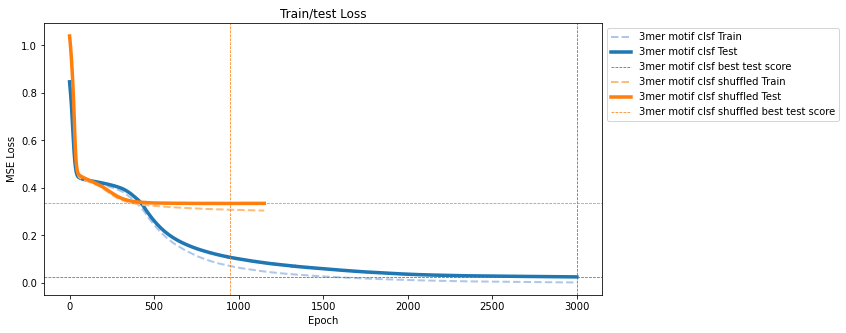

In [19]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

Let's also look at the confusion matrix results for the shuffled sequence model:

Running predictions for 3mer motif clsf shuffled


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


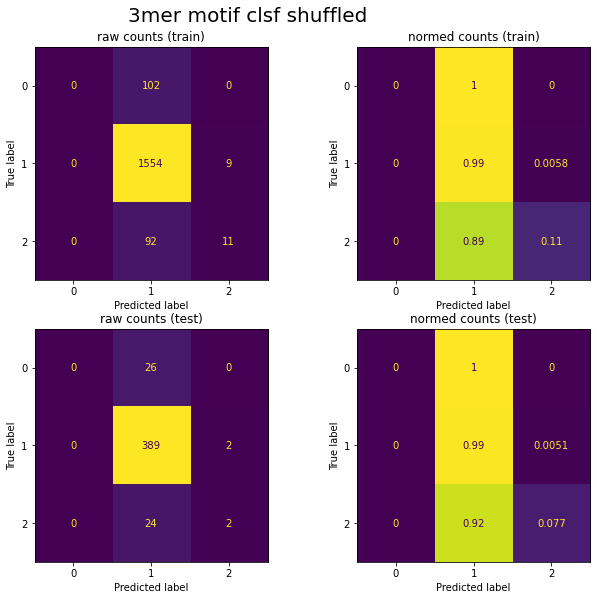

In [20]:
seq_list_shuff = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn2_name] = tu.get_confusion_stats(
    model_res[cnn2_name]['model'],
    model_res[cnn2_name]['model_name'],
    seq_list_shuff,
    DEVICE,
    title=f"{model_res[cnn2_name]['model_name']}"
)

In [21]:
pred_dfs[cnn2_name]

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,3mer motif clsf shuffled,train,0.479672,0.367013,0.372517,1768
1,3mer motif clsf shuffled,test,0.462035,0.357269,0.356894,443


In the confusion matrices, we see that the model is only predicting the majority class. Additionally, the Macro-F1 score (class-balanced F1 score that balances precision and recall), is close to 1/3 (which makes sense because in this 3-class classification task, it predicted 1 class correctly (majority class 1) but was not able to predict the 2 other minority classes. 

### Try one more really small model
Our first CNN model was very simple, but had 8 filters, which is several more than what should be needed to learn the underlying signal of 3 motifs. Just to see, let's try 1 more model, trained on the original (not shuffled) sequences but only use 2 filters instead of 8 to see what happens. 

E:2999 | train loss:0.062 | val loss: 0.111: 100%|██████████| 3000/3000 [01:56<00:00, 25.83it/s]


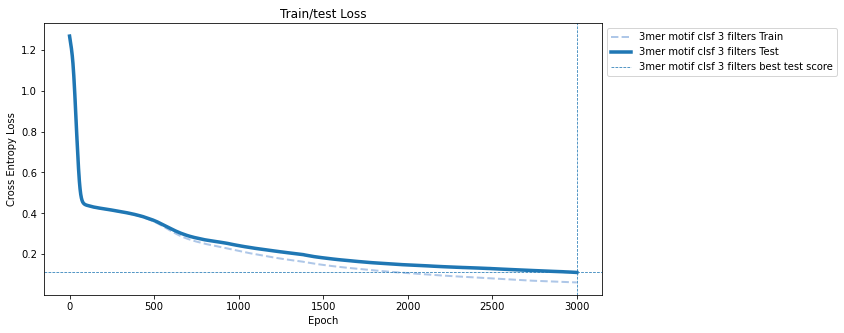

Running predictions for 3mer motif clsf 3 filters


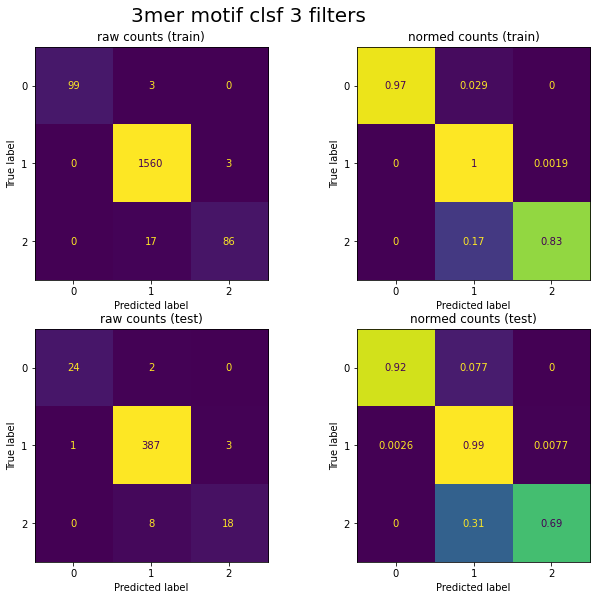

In [22]:
# Model set up
cnn3_name = "3mer motif clsf 3 filters"
model3 = m.DNA_CNN(
    seq_len,
    num_classes=3,
    num_filters=3,
    kernel_size=3,
    fc_node_num=10,
    dropout=0
)

# Model training
model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='classification'
)

# Model evaluation
pred_dfs[cnn3_name] = tu.get_confusion_stats(
    model_res[cnn3_name]['model'],
    model_res[cnn3_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn3_name]['model_name']}"
)

In [23]:
pred_dfs[cnn3_name]

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,3mer motif clsf 3 filters,train,0.984545,0.934540,0.957863,1768
1,3mer motif clsf 3 filters,test,0.930651,0.868385,0.896456,443


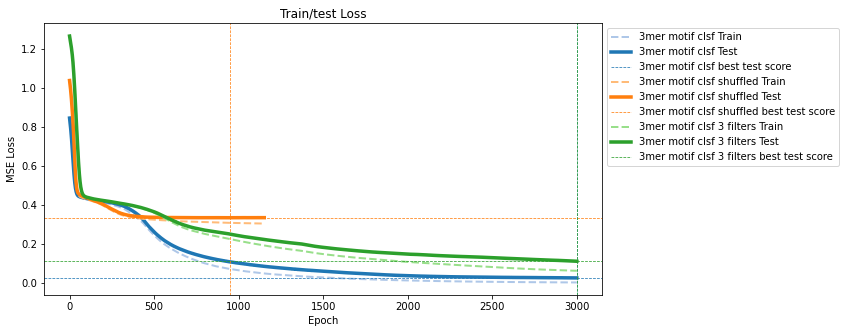

In [24]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

Even with this tiny CNN model, the classification accuracy was still quite good: F1 = 0.9 on the test set. The loss curve was a bit slower on the trend towards 0, but not too shabby!

Checking the filters, I thought maybe the signal would be clearer since it was limited in what patterns in could learn, but I guess these filters were fine enough to get by. 

Total convolutional layers: 1
Num filters 3
filt_width 3
Seq 0 of 1768
Seq 100 of 1768
Seq 200 of 1768
Seq 300 of 1768
Seq 400 of 1768
Seq 500 of 1768
Seq 600 of 1768
Seq 700 of 1768
Seq 800 of 1768
Seq 900 of 1768
Seq 1000 of 1768
Seq 1100 of 1768
Seq 1200 of 1768
Seq 1300 of 1768
Seq 1400 of 1768
Seq 1500 of 1768
Seq 1600 of 1768
Seq 1700 of 1768
torch.Size([3, 4, 3])


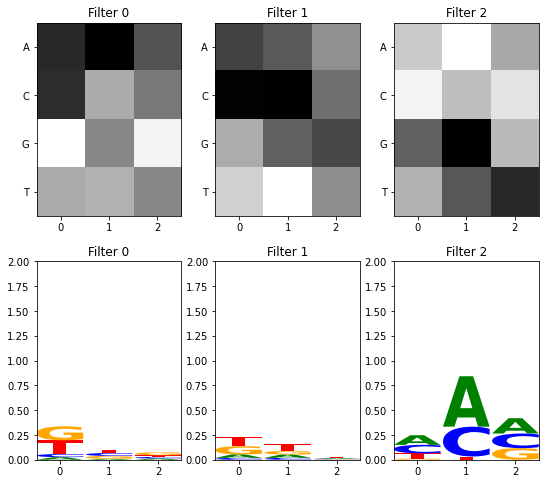

In [25]:
seqs = train_df['seq6'].values
v.view_conv2D_wrapper(model3,seqs,DEVICE,act_thresh=0.5,ysc=0.5)

## Summary of classification results for Task 1

In [26]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,3mer motif clsf,train,1.000000,1.000000,1.000000,1768
1,3mer motif clsf,test,0.972654,0.972654,0.972654,443
0,3mer motif clsf shuffled,train,0.479672,0.367013,0.372517,1768
1,3mer motif clsf shuffled,test,0.462035,0.357269,0.356894,443
0,3mer motif clsf 3 filters,train,0.984545,0.934540,0.957863,1768
1,3mer motif clsf 3 filters,test,0.930651,0.868385,0.896456,443


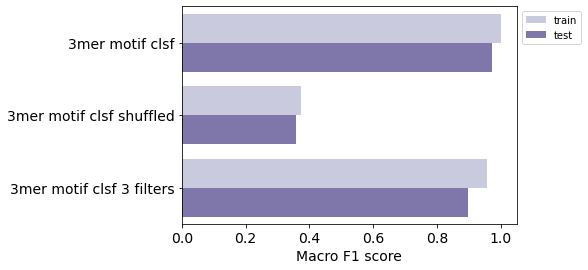

In [27]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True,palette='Purples')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

This notebook demonstrates a relatively simple DNA-sequence learning example: predict sequence class based on the presence or absence of a 3-mer motif within a 6bp sequence window. 

Even a really small model with only 3 filters was able to accomplish this task reasonably well (though more slowly). When the sequences are shuffled (thereby destroying the original signal by which the sequences were assigned classes), the models are no longer after to learn to classify them. 

Now let's increase the difficulty of the synthetic task.

For the next analysis, we investigate longer sequence windows: 300bp long (instead of reducing to 6bp) and see if we can learn to classify examples based on a pair of 6-mers motifs. 

See `synthetic_DNAclassification_task2_harder.ipynb`